<a href="https://colab.research.google.com/github/acesur/Machine-Learning-/blob/main/02_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Path 1 exists: True
Path 2 exists: True
Metadata exists: True
Metadata shape: (10015, 7)
Metadata columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Sample files in directory 1:
ISIC_0024306.jpg
ISIC_0024307.jpg
ISIC_0024308.jpg
ISIC_0024309.jpg
ISIC_0024310.jpg
ISIC_0024311.jpg
ISIC_0024312.jpg
ISIC_0024313.jpg
ISIC_0024314.jpg
ISIC_0024315.jpg

Sample files in directory 2:
ISIC_0029306.jpg
ISIC_0029307.jpg
ISIC_0029308.jpg
ISIC_0029309.jpg
ISIC_0029310.jpg
ISIC_0029311.jpg
ISIC_0029312.jpg
ISIC_0029313.jpg
ISIC_0029314.jpg
ISIC_0029315.jpg

Testing improved image finding function:
ID: ISIC_0027419, Found: Yes, Path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg
ID: ISIC_0025030, Found: Yes, Path: /kaggle/input/skin-cancer-mnis

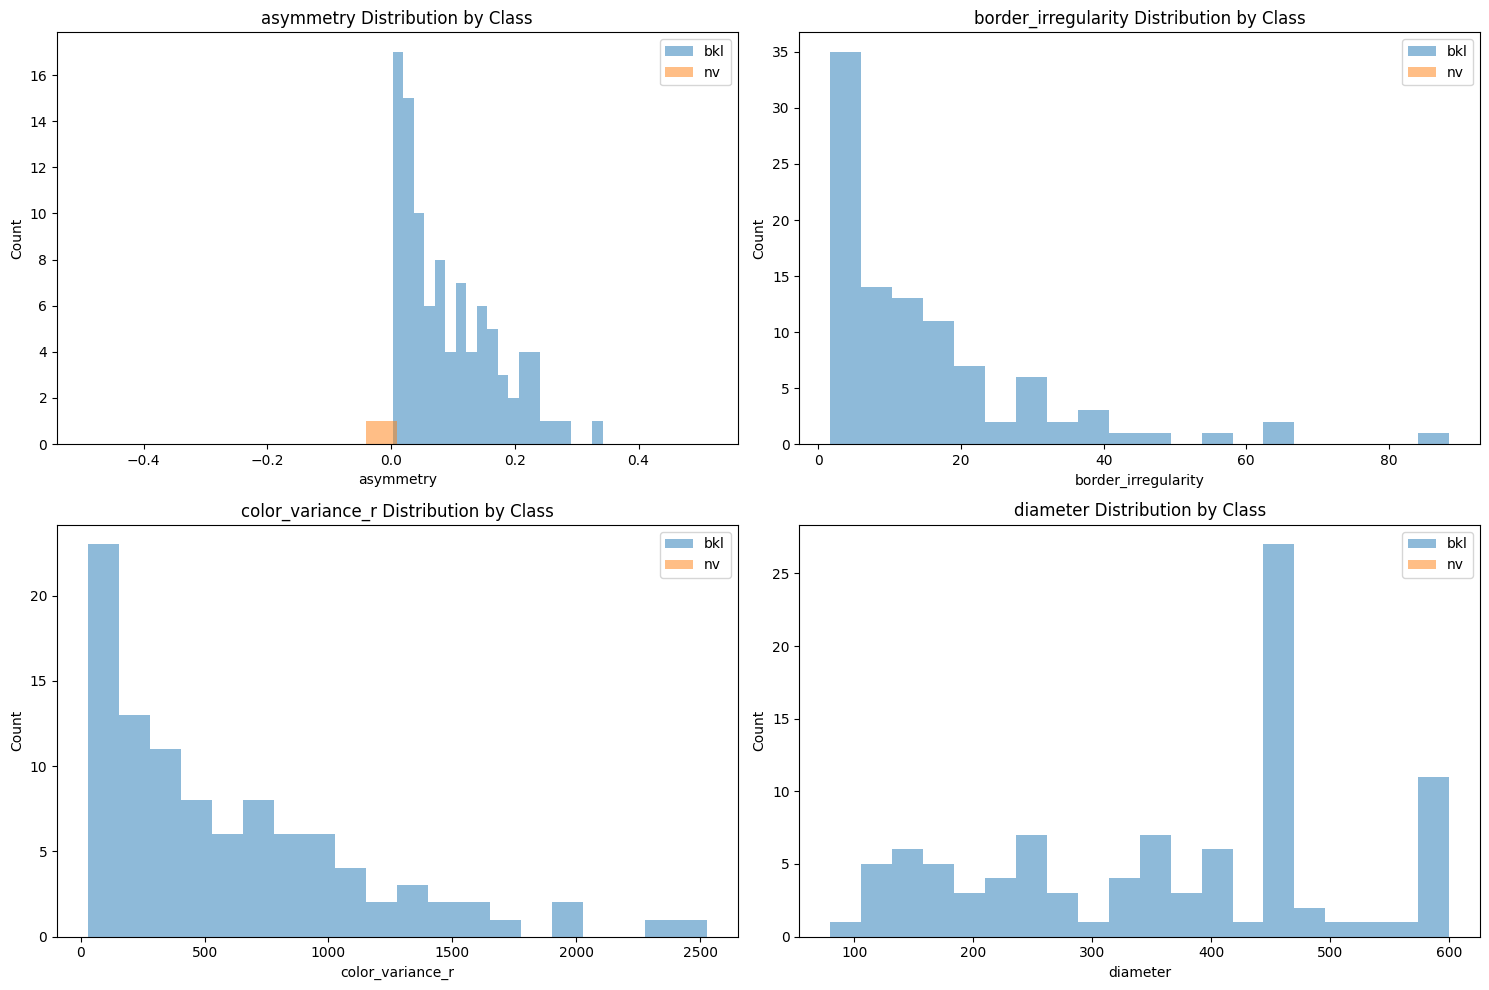

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)
# Paths to your data
from google.colab import drive
drive.mount('/content/drive/')

# Define paths to your data
# IMAGES_PATH_PART1 = "/content/drive/My Drive/Colab Notebooks/dataset/archive (2)/HAM10000_images_part_1"
# IMAGES_PATH_PART2 = "/content/drive/My Drive/Colab Notebooks/dataset/archive (2)/HAM10000_images_part_2"
# METADATA_PATH = "/content/drive/My Drive/Colab Notebooks/dataset/archive (2)/HAM10000_metadata.csv"

IMAGES_PATH_PART1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMAGES_PATH_PART2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
# Check if paths exist
print(f"Path 1 exists: {os.path.exists(IMAGES_PATH_PART1)}")
print(f"Path 2 exists: {os.path.exists(IMAGES_PATH_PART2)}")
print(f"Metadata exists: {os.path.exists(METADATA_PATH)}")

# Load metadata
metadata = pd.read_csv(METADATA_PATH)
print(f"Metadata shape: {metadata.shape}")
print(f"Metadata columns: {metadata.columns.tolist()}")

# Look at some sample filenames to understand the pattern
print("\nSample files in directory 1:")
try:
    files1 = sorted(os.listdir(IMAGES_PATH_PART1))[:10]
    for f in files1:
        print(f)
except Exception as e:
    print(f"Error listing directory 1: {e}")

print("\nSample files in directory 2:")
try:
    files2 = sorted(os.listdir(IMAGES_PATH_PART2))[:10]
    for f in files2:
        print(f)
except Exception as e:
    print(f"Error listing directory 2: {e}")

def find_image_path_improved(image_id, part1_path, part2_path):
    """
    Enhanced function to find image paths with better handling of different naming patterns.
    This function tries multiple approaches to locate images based on their IDs.

    Args:
        image_id (str): The image ID from the metadata
        part1_path (str): Path to the first image directory
        part2_path (str): Path to the second image directory

    Returns:
        str or None: The full path to the image if found, None otherwise
    """
    # First, try the exact filename with ISIC prefix
    if image_id.startswith('ISIC_'):
        base_id = image_id
        numeric_id = image_id.replace('ISIC_', '')
    else:
        base_id = f"ISIC_{image_id}"
        numeric_id = image_id

    # List of possible filename patterns to try
    patterns = [
        f"{base_id}.jpg",                 # ISIC_XXXX.jpg
        f"{numeric_id}.jpg",              # XXXX.jpg
        f"{base_id.lower()}.jpg",         # isic_xxxx.jpg (lowercase)
        f"{numeric_id.lower()}.jpg"       # xxxx.jpg (lowercase)
    ]

    # Try all patterns in both directories
    for pattern in patterns:
        # Check in part1
        path = os.path.join(part1_path, pattern)
        if os.path.exists(path):
            return path

        # Check in part2
        path = os.path.join(part2_path, pattern)
        if os.path.exists(path):
            return path

    # If exact patterns fail, try using glob for more flexible matching
    for directory in [part1_path, part2_path]:
        # Try with the full ID
        possible_files = glob(os.path.join(directory, f"*{base_id}*"))
        if possible_files:
            return possible_files[0]

        # Try with just the numeric part
        possible_files = glob(os.path.join(directory, f"*{numeric_id}*"))
        if possible_files:
            return possible_files[0]

    # If all previous attempts fail, do a complete listing and search
    # This is more expensive but will catch edge cases
    try:
        all_files_part1 = [f for f in os.listdir(part1_path) if f.endswith('.jpg')]
        all_files_part2 = [f for f in os.listdir(part2_path) if f.endswith('.jpg')]

        for filename in all_files_part1 + all_files_part2:
            # Remove file extension and clean up
            name_without_ext = filename.split('.')[0].lower()

            # Try to match with the numeric part
            if numeric_id.lower() in name_without_ext:
                if filename in all_files_part1:
                    return os.path.join(part1_path, filename)
                else:
                    return os.path.join(part2_path, filename)
    except Exception as e:
        print(f"Error during exhaustive search: {e}")

    # If we still can't find the image, create an ID to file mapping as a last resort
    if getattr(find_image_path_improved, 'id_to_file_map', None) is None:
        try:
            # Create a mapping only once and store it
            find_image_path_improved.id_to_file_map = {}

            all_files_part1 = [os.path.join(part1_path, f) for f in os.listdir(part1_path) if f.endswith('.jpg')]
            all_files_part2 = [os.path.join(part2_path, f) for f in os.listdir(part2_path) if f.endswith('.jpg')]
            all_files = all_files_part1 + all_files_part2

            for file_path in all_files:
                filename = os.path.basename(file_path).lower()
                # Build a mapping with various ID formats
                if 'isic_' in filename:
                    file_id_with_prefix = filename.replace('.jpg', '')
                    file_id_without_prefix = filename.replace('isic_', '').replace('.jpg', '')
                    find_image_path_improved.id_to_file_map[file_id_with_prefix] = file_path
                    find_image_path_improved.id_to_file_map[file_id_without_prefix] = file_path
                else:
                    file_id = filename.replace('.jpg', '')
                    find_image_path_improved.id_to_file_map[file_id] = file_path
                    find_image_path_improved.id_to_file_map[f"isic_{file_id}"] = file_path

            # Now try the mapping
            for id_variant in [base_id.lower(), numeric_id.lower()]:
                if id_variant in find_image_path_improved.id_to_file_map:
                    return find_image_path_improved.id_to_file_map[id_variant]
        except Exception as e:
            print(f"Error creating ID to file mapping: {e}")

    # If we get here, we couldn't find the image
    return None

def extract_abcd_features_robust(image_path):
    """
    Extract ABCD features with robust error handling
    """
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}")
            return None

        # Get dimensions
        height, width, _ = img.shape

        # Convert to RGB for processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert to grayscale for some calculations
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Apply multiple thresholding methods
        _, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY_INV, 11, 2)

        # Try both thresholding methods
        for thresh, method_name in [(thresh_otsu, "Otsu"), (thresh_adaptive, "Adaptive")]:
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # If no contours found with this method, try the next
            if not contours:
                continue

            # Get the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            contour_area = cv2.contourArea(largest_contour)

            # If contour area is too small, try next method
            if contour_area < 100:
                continue

            # Create mask from the largest contour
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [largest_contour], 0, 255, -1)

            # Asymmetry calculation
            h, w = mask.shape
            flipped_mask = cv2.flip(mask, 1)
            asymmetry = np.sum(np.abs(mask - flipped_mask)) / (h * w * 255)

            # Border irregularity
            perimeter = cv2.arcLength(largest_contour, True)
            border_irregularity = perimeter**2 / (4 * np.pi * contour_area) if contour_area > 0 else 0

            # Color variation
            r, g, b = cv2.split(img)
            mask_bool = mask > 0

            if np.sum(mask_bool) > 0:
                color_variance_r = np.var(r[mask_bool])
                color_variance_g = np.var(g[mask_bool])
                color_variance_b = np.var(b[mask_bool])
            else:
                color_variance_r = color_variance_g = color_variance_b = 0

            # Diameter
            x, y, w, h = cv2.boundingRect(largest_contour)
            diameter = max(w, h)

            return {
                'asymmetry': float(asymmetry),
                'border_irregularity': float(border_irregularity),
                'color_variance_r': float(color_variance_r),
                'color_variance_g': float(color_variance_g),
                'color_variance_b': float(color_variance_b),
                'diameter': float(diameter)
            }

        # If both methods failed, use basic image stats
        mean_r = np.mean(img[:,:,0])
        mean_g = np.mean(img[:,:,1])
        mean_b = np.mean(img[:,:,2])
        var_r = np.var(img[:,:,0])
        var_g = np.var(img[:,:,1])
        var_b = np.var(img[:,:,2])

        return {
            'asymmetry': 0.0,
            'border_irregularity': 1.0,
            'color_variance_r': float(var_r),
            'color_variance_g': float(var_g),
            'color_variance_b': float(var_b),
            'diameter': float(max(height, width) / 2)
        }

    except Exception as e:
        print(f"Error in feature extraction for {image_path}: {str(e)}")
        return None

# Test the improved function with a few sample images
print("\nTesting improved image finding function:")
for i in range(5):
    test_id = metadata.iloc[i]['image_id']
    path = find_image_path_improved(test_id, IMAGES_PATH_PART1, IMAGES_PATH_PART2)
    print(f"ID: {test_id}, Found: {'Yes' if path else 'No'}, Path: {path}")

# Extract features using the improved function
feature_results = []
success_count = 0
failure_count = 0

# Limit sample size for testing
sample_size = min(100, len(metadata))

for i, row in metadata.head(sample_size).iterrows():
    img_id = row['image_id']
    img_path = find_image_path_improved(img_id, IMAGES_PATH_PART1, IMAGES_PATH_PART2)

    if img_path:
        features = extract_abcd_features_robust(img_path)
        if features:
            features['image_id'] = img_id
            features['dx'] = row['dx']  # Use dx to match metadata column
            feature_results.append(features)
            success_count += 1
        else:
            failure_count += 1
    else:
        print(f"Could not find image for ID: {img_id}")
        failure_count += 1

    # Print progress
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{sample_size} images, Success: {success_count}, Failures: {failure_count}")

print(f"Final count - Success: {success_count}, Failures: {failure_count}")

# Convert to DataFrame only if we have results
if feature_results:
    feature_df = pd.DataFrame(feature_results)

    # Display sample results
    print("Feature DataFrame shape:", feature_df.shape)
    print("Feature DataFrame columns:", feature_df.columns.tolist())
    print("Feature DataFrame preview:")
    print(feature_df.head())
    # Save features to CSV
    feature_df.to_csv('/content/drive/My Drive/Colab Notebooks/dataset/abcd_features.csv', index=False)


    # Visualize feature distributions by class
    plt.figure(figsize=(15, 10))

    features_to_plot = ['asymmetry', 'border_irregularity', 'color_variance_r', 'diameter']
    for i, feature in enumerate(features_to_plot):
        plt.subplot(2, 2, i+1)
        for diagnosis in feature_df['dx'].unique():  # Using 'dx' instead of 'diagnosis'
            subset = feature_df[feature_df['dx'] == diagnosis]
            plt.hist(subset[feature], alpha=0.5, label=diagnosis, bins=20)

        plt.title(f'{feature} Distribution by Class')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No features were successfully extracted. Check paths and image processing.")